In [1]:
import numpy as np
import pandas as pd
from astropy.io import fits
import os
from astropy.table import Table
from scipy.spatial import KDTree

import matplotlib.pyplot as plt

from IPython.display import Image
from IPython.core.display import HTML 

In [2]:
import torch
from torch.utils.data import DataLoader, dataset, TensorDataset
from torch import nn, optim
from torch.optim import lr_scheduler

In [3]:
import sys
sys.path.append('../insight')
from archive import archive 
from insight_arch import Photoz_network
from insight import Insight_module
from utils import sigma68, nmad, plot_photoz_estimates
from scipy import stats
from scipy.stats import norm


In [4]:
from matplotlib import rcParams
rcParams["mathtext.fontset"] = "stix"
rcParams["font.family"] = "STIXGeneral"
parent_dir = '/data/astro/scratch2/lcabayol/insight/data/Euclid_EXT_MER_PHZ_DC2_v1.5'

In [5]:
photoz_archive = archive(path = parent_dir,only_zspec=True,flags_kept=[1. , 1.1, 1.4, 1.5, 2,2.1,2.4,2.5,3., 3.1, 3.4, 3.5,  4., 9. , 9.1, 9.3, 9.4, 9.5,11.1, 11.5, 12.1, 12.5, 13. , 13.1, 13.5, 14, ])
f, ferr, specz ,VIS_mag = photoz_archive.get_training_data()
f_test, ferr_test, specz_test ,VIS_mag_test = photoz_archive.get_testing_data()


In [18]:
nnz = Photoz_network(num_gauss=6)
insight = Insight_module(nnz, batch_size=100)
insight.train(input_data=f, 
              target_data=specz, 
              nepochs=300, 
              step_size = 200, 
              val_fraction=0.1, 
              lr=1e-3
             )

training_loss:-0.21270108222961426 testing_loss:-0.04698280245065689
training_loss:-0.23676402866840363 testing_loss:0.43857431411743164
training_loss:-0.1989772915840149 testing_loss:-0.5890757441520691
training_loss:-0.15348327159881592 testing_loss:-0.2529553472995758
training_loss:-0.30240100622177124 testing_loss:-0.6529129147529602
training_loss:-0.5496183037757874 testing_loss:-1.2374480962753296
training_loss:-0.30388739705085754 testing_loss:-0.7149669528007507
training_loss:-0.4546045958995819 testing_loss:-0.08964099735021591
training_loss:-0.5609608292579651 testing_loss:-0.6262155771255493
training_loss:-0.48281827569007874 testing_loss:-1.3634161949157715
training_loss:-0.6078523397445679 testing_loss:-0.9701372981071472
training_loss:-0.7257784605026245 testing_loss:-0.8324934840202332
training_loss:-0.5457053184509277 testing_loss:-0.8311973810195923
training_loss:-0.8498871922492981 testing_loss:-1.0593522787094116
training_loss:-0.8659066557884216 testing_loss:-1.3713

In [19]:
z,zerr, pz = insight.get_pz(input_data=torch.Tensor(f_test), target_data=torch.Tensor(specz_test),return_pz=True)
df = pd.DataFrame(np.c_[VIS_mag_test, specz_test,z,zerr], columns = ['VISmag','zs','z','zuncert'])
df['zwerr'] = (df.z -df.zs) / (1+df.zs)



In [20]:
nmad(df.zwerr)

0.054412555810143

In [21]:
zgrid = np.linspace(0, 4, 1000)

In [22]:
pz = pz / pz.sum(1)[:,None]

In [23]:
diff_matrix = np.abs(z[:,None] - zgrid[None,:])
idx = np.argmin(diff_matrix,1)


In [24]:
p_z_x = np.zeros(shape=(len(pz)))
for ii in range(len(pz)):
    p_z_x[ii] = pz[ii,idx[ii]]

In [25]:
df['p_z_x'] =p_z_x

(array([-1. , -0.5,  0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5]),
 [Text(0, -1.0, '−1.0'),
  Text(0, -0.5, '−0.5'),
  Text(0, 0.0, '0.0'),
  Text(0, 0.5, '0.5'),
  Text(0, 1.0, '1.0'),
  Text(0, 1.5, '1.5'),
  Text(0, 2.0, '2.0'),
  Text(0, 2.5, '2.5'),
  Text(0, 3.0, '3.0'),
  Text(0, 3.5, '3.5')])

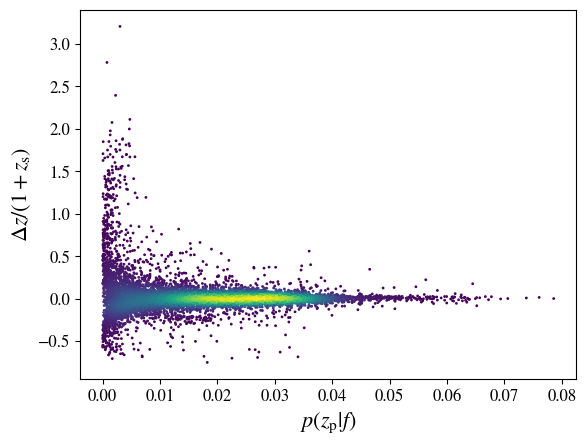

In [26]:
from scipy.stats import gaussian_kde
xy = np.vstack([df.p_z_x,df.zwerr])
c = gaussian_kde(xy)(xy)

fig, ax = plt.subplots()

plt.scatter(df.p_z_x,df.zwerr, c=c,s=1)

plt.xlabel(r'$p(z_{\rm p}|f)$', fontsize=16)
plt.ylabel(r'$\Delta z / (1 + z_{\rm s})$', fontsize=16)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

#plt.savefig('FLAGvsERROR.pdf', bbox_inches='tight')

(array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.]),
 [Text(0, -1.0, '−1'),
  Text(0, 0.0, '0'),
  Text(0, 1.0, '1'),
  Text(0, 2.0, '2'),
  Text(0, 3.0, '3'),
  Text(0, 4.0, '4'),
  Text(0, 5.0, '5'),
  Text(0, 6.0, '6')])

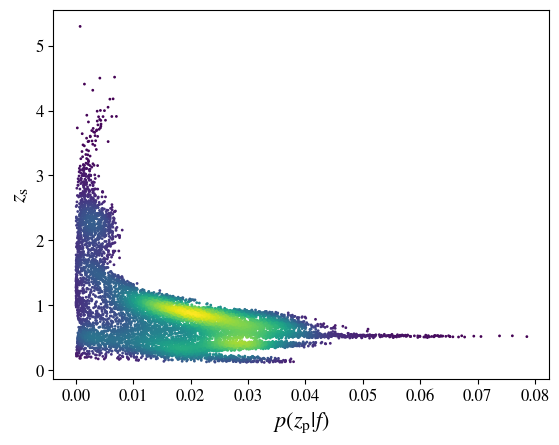

In [27]:
xy = np.vstack([df.p_z_x,df.z])
c = gaussian_kde(xy)(xy)

fig, ax = plt.subplots()

plt.scatter(df.p_z_x,df.z, c=c,s=1)

plt.xlabel(r'$p(z_{\rm p}|f)$', fontsize=16)
plt.ylabel(r'$z_{\rm s}$', fontsize=16)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

#plt.savefig('FLAGvsz.pdf', bbox_inches='tight')

(array([14., 16., 18., 20., 22., 24., 26., 28.]),
 [Text(0, 14.0, '14'),
  Text(0, 16.0, '16'),
  Text(0, 18.0, '18'),
  Text(0, 20.0, '20'),
  Text(0, 22.0, '22'),
  Text(0, 24.0, '24'),
  Text(0, 26.0, '26'),
  Text(0, 28.0, '28')])

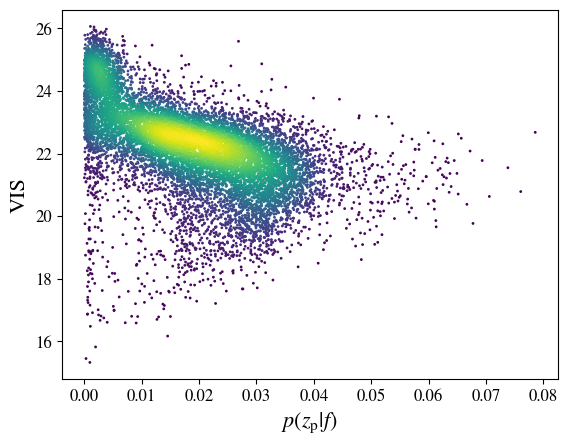

In [28]:
xy = np.vstack([df.p_z_x,df.VISmag])
c = gaussian_kde(xy)(xy)

fig, ax = plt.subplots()

plt.scatter(df.p_z_x,df.VISmag, c=c,s=1)

plt.xlabel(r'$p(z_{\rm p}|f)$', fontsize=16)
plt.ylabel(r'VIS', fontsize=16)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

#plt.savefig('FLAGvsVIS.pdf', bbox_inches='tight')

In [29]:
bin_edges = stats.mstats.mquantiles(df.p_z_x, np.arange(0,1.01,0.05))
scatter, eta,xlab = [],[],[]

for k in range(len(bin_edges)-1):
    edge_min = bin_edges[k]
    edge_max = bin_edges[k+1]
    
    
    
    df_bin = df[(df.p_z_x > edge_min)]    
    

    
    xlab.append(np.round(len(df_bin)/len(df),2)*100)
    scatter.append(nmad(df_bin.zwerr))
    eta.append(len(df_bin[np.abs(df_bin.zwerr)>0.15])/len(df)*100)



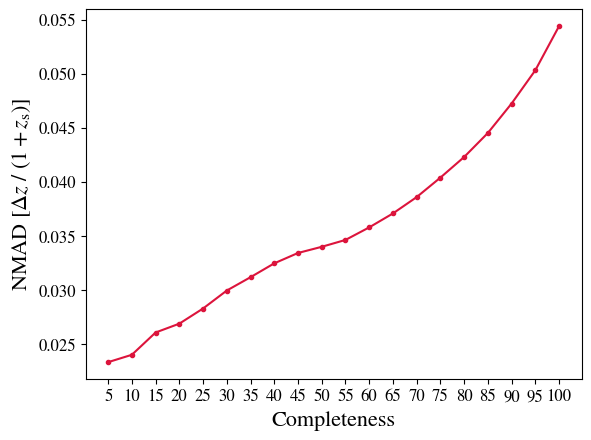

In [30]:
plt.plot(xlab,scatter, marker = '.', color ='crimson')


plt.ylabel(r'NMAD [$\Delta z\ /\ (1 + z_{\rm s})$]', fontsize=16)
plt.xlabel('Completeness', fontsize=16)

plt.yticks(fontsize=12)
plt.xticks(np.arange(5,101,5), fontsize=12)
#plt.savefig('FLAG_NMAD.pdf', bbox_inches='tight')
plt.show()

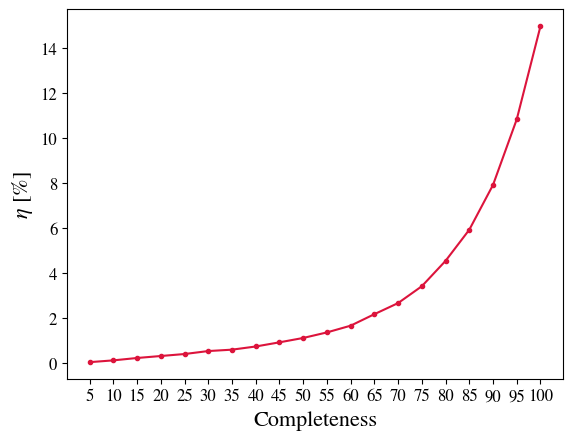

In [31]:
plt.plot(xlab,eta, marker='.', color ='crimson')
plt.yticks(fontsize=12)
plt.xticks(np.arange(5,101,5), fontsize=12)
plt.ylabel(r'$\eta$ [%]', fontsize=16)
plt.xlabel('Completeness', fontsize=16)
#plt.savefig('FLAG_outliers.pdf', bbox_inches='tight')

plt.show()

## TEST PDF

In [32]:
pit_list = insight.pit(input_data=torch.Tensor(f_test), target_data=torch.Tensor(specz_test))

In [33]:
crps_list = insight.crps(input_data=torch.Tensor(f_test), target_data=specz_test)

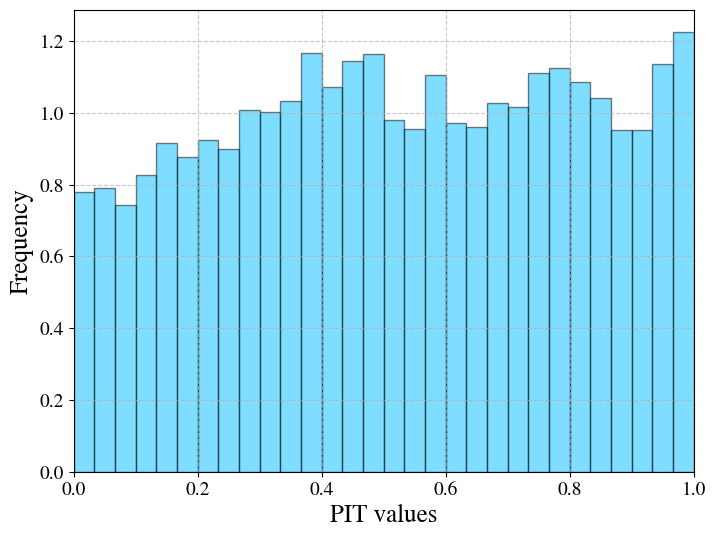

In [34]:

# Assuming you have 'crps_list' with your CRPS scores

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Create a histogram
hist, bins, _ = ax.hist(pit_list, range=(0, 1), bins=30, color='deepskyblue', alpha=0.5, edgecolor='black', density=True)

# Add labels and a title
ax.set_xlabel('PIT values', fontsize = 18)
ax.set_ylabel('Frequency', fontsize = 18)

# Add grid lines
ax.grid(True, linestyle='--', alpha=0.7)

# Customize the x-axis
ax.set_xlim(0, 1)

# Make ticks larger
ax.tick_params(axis='both', which='major', labelsize=14)



# Show the plot
plt.show()


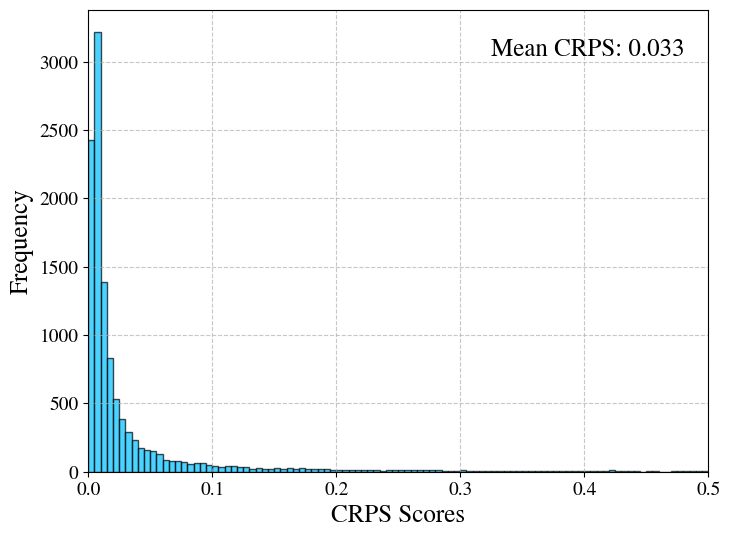

In [35]:
import matplotlib.pyplot as plt

# Assuming you have 'crps_list' with your CRPS scores

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Create a histogram
hist, bins, _ = ax.hist(crps_list, range=(0, 0.5), bins=100, color='deepskyblue', alpha=0.7, edgecolor='black')

# Add labels and a title
ax.set_xlabel('CRPS Scores', fontsize = 18)
ax.set_ylabel('Frequency', fontsize = 18)

# Add grid lines
ax.grid(True, linestyle='--', alpha=0.7)

# Customize the x-axis
ax.set_xlim(0, 0.5)

# Make ticks larger
ax.tick_params(axis='both', which='major', labelsize=14)

# Calculate the mean CRPS value
mean_crps = round(np.mean(crps_list), 3)

# Add the mean CRPS value at the top-left corner
ax.annotate(f"Mean CRPS: {mean_crps}", xy=(0.65, 0.9), xycoords='axes fraction', fontsize=18)

# Show the plot
plt.show()


In [ ]:
m = 600
# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the PDF with a label
ax.plot(np.linspace(0, 4, 1000), pz[m], label='PDF', color='navy')
#ax.plot(np.linspace(0, 4, 1000), np.cumsum(pz[m]),  label='CDF', color = 'forestgreen', ls=':')

# Add a vertical line for 'specz_test'
ax.axvline(specz_test[m], color='black', linestyle='--', label=r'$z_{\rm s}$')

# Add labels and a legend
ax.set_xlabel(r'$z$', fontsize = 18)
ax.set_ylabel('Probability Density', fontsize=16)
ax.legend(fontsize = 18)

# Display the plot
plt.show()